In [1]:
%pip install torch_geometric
%pip install structlog

In [2]:
from structlog import get_logger
logger = get_logger()

# Data Seting up

In [3]:
# Initialization: Load shared functions and simulated data

# Load shared functions
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py

# Get simulated data from Github repository
if not os.path.exists("simulated-data-transformed"):
    !git clone https://github.com/Fraud-Detection-Handbook/simulated-data-transformed

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63257  100 63257    0     0   221k      0 --:--:-- --:--:-- --:--:--  222k


In [4]:
from datetime import datetime, timedelta

PKL_FOLDER = "./simulated-data-transformed/data"

transactions_dfs = []
for filename in os.listdir(PKL_FOLDER):
    if filename.endswith(".pkl"):
        #print(filename)
        # concat df
        transactions_df = transactions_dfs.append(pd.read_pickle(os.path.join(PKL_FOLDER, filename)))

transactions_df = pd.concat(transactions_dfs).sort_values(by=["TX_DATETIME"])
transactions_df.head()
del transactions_dfs

In [5]:
start_date_training = datetime(2018, 4, 1) # (Timestamp('2018-04-01 00:00:31'), Timestamp('2018-09-30 23:59:57'))

(train_df, test_df) = get_train_test_set(transactions_df,start_date_training,
                                         delta_train=90,delta_delay=1,delta_test=50, sampling_ratio=1)

# remove fault scenario 1) it does not make sense for graph ML (there is no gain on aggregatting information )
(train_df, test_df) = train_df[train_df["TX_FRAUD_SCENARIO"] != 1], test_df[test_df["TX_FRAUD_SCENARIO"] != 1]


# Add a feature with the day as elapsed seconds
start_date = train_df["TX_DATETIME"].min()
train_df = train_df.assign(TX_TIME_ELAPSED_SECONDS=lambda df: (df["TX_DATETIME"] - start_date_training).dt.total_seconds())
test_df = test_df.assign(TX_TIME_ELAPSED_SECONDS=lambda df: (df["TX_DATETIME"] - start_date_training).dt.total_seconds())



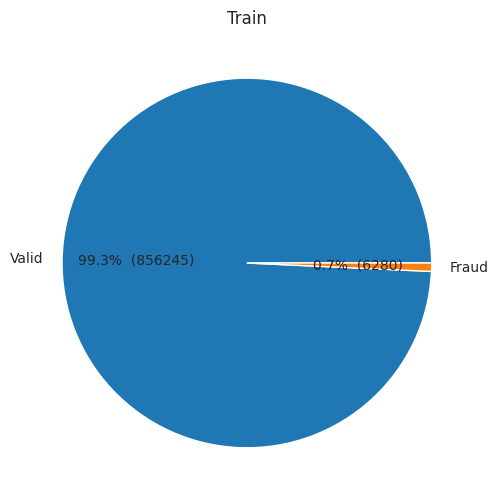

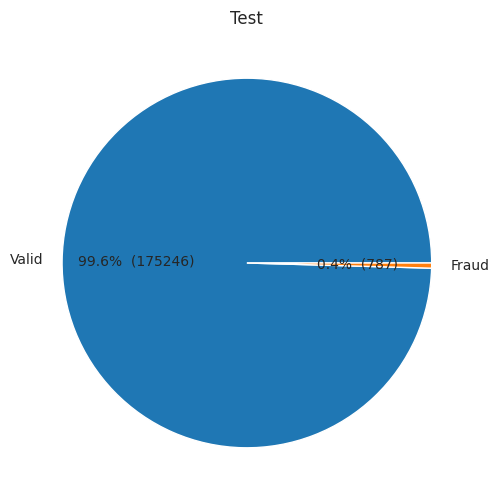

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_fraud_proportion(df, label="test"):
  # Custom autopct function to show both count and percentage
  def make_autopct(counts):
      counts = list(counts)
      def my_autopct(pct):
          val = int(counts.pop(0))
          return '{p:.1f}%  ({v:d})'.format(p=pct, v=val)
      return my_autopct

  # print pie plot with proportion for each category
  sns.set_style("whitegrid")
  plt.figure(figsize=(6,6))
  counts = df['TX_FRAUD'].value_counts().values

  plt.pie(df['TX_FRAUD'].value_counts(normalize=True).values, labels=["Valid", "Fraud"], autopct=make_autopct(counts),)
  plt.title(label)
  plt.show()

plot_fraud_proportion(train_df, "Train")
plot_fraud_proportion(test_df, "Test")







In [7]:
ORIGINAL_COLUMNS = ['TRANSACTION_ID', 'TX_DATETIME', 'CUSTOMER_ID', 'TERMINAL_ID',
       'TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TX_FRAUD',
       'TX_FRAUD_SCENARIO', 'TX_DURING_WEEKEND', 'TX_DURING_NIGHT',
       'CUSTOMER_ID_NB_TX_1DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW',
       'CUSTOMER_ID_NB_TX_7DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW',
       'CUSTOMER_ID_NB_TX_30DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW',
       'TERMINAL_ID_NB_TX_1DAY_WINDOW', 'TERMINAL_ID_RISK_1DAY_WINDOW',
       'TERMINAL_ID_NB_TX_7DAY_WINDOW', 'TERMINAL_ID_RISK_7DAY_WINDOW',
       'TERMINAL_ID_NB_TX_30DAY_WINDOW', 'TERMINAL_ID_RISK_30DAY_WINDOW']

COLUMS_TO_KEEP = ['TRANSACTION_ID', 'TX_DATETIME', 'CUSTOMER_ID', 'TERMINAL_ID','TX_AMOUNT', 'TX_FRAUD',  # These are the original columns in a transaction
                  'TX_FRAUD_SCENARIO', "TX_TIME_ELAPSED_SECONDS"]

FEATURES_TO_TRAIN_GNN = ['CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT', "TX_TIME_ELAPSED_SECONDS"]

train_df = train_df[COLUMS_TO_KEEP]
test_df = test_df[COLUMS_TO_KEEP]

train_df.reset_index(drop=True, inplace=True)
train_df["TRANSACTION_ID"] = train_df.index
train_df

test_df.reset_index(drop=True, inplace=True)
test_df["TRANSACTION_ID"] = max(train_df["TRANSACTION_ID"]) + 1 + test_df.index
test_df.index = range(min(test_df["TRANSACTION_ID"]), max(test_df["TRANSACTION_ID"]) + 1)
test_df

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,TX_FRAUD_SCENARIO,TX_TIME_ELAPSED_SECONDS
862525,862525,2018-07-01 00:03:28,3908,857,24.75,0,0,7862608.0
862526,862526,2018-07-01 00:07:33,3973,6182,42.60,0,0,7862853.0
862527,862527,2018-07-01 00:07:45,2808,9631,74.92,0,0,7862865.0
862528,862528,2018-07-01 00:10:25,1562,3393,49.26,0,0,7863025.0
862529,862529,2018-07-01 00:11:12,719,6074,70.32,0,0,7863072.0
...,...,...,...,...,...,...,...,...
1038553,1038553,2018-08-19 23:44:45,3700,7608,110.09,0,0,12181485.0
1038554,1038554,2018-08-19 23:54:13,4422,705,41.37,0,0,12182053.0
1038555,1038555,2018-08-19 23:55:28,2432,4452,41.84,0,0,12182128.0
1038556,1038556,2018-08-19 23:56:39,4941,4860,119.64,0,0,12182199.0


# Edge Generators

In [8]:
from typing import List, Callable

def connect_transaction_same_customer_last_x_days(transaction_df, last_x_days):
    """
    Connect transitions for the same customer within the specified number of days.

    Parameters:
    - transaction_df: pd.DataFrame - DataFrame containing transitions with 'CUSTOMER_ID' and 'TX_DATETIME' columns.
    - last_x_days: int - Time window in days to consider valid transitions.
    """
    # Group by 'CUSTOMER_ID'
    grouped = transaction_df.groupby('CUSTOMER_ID')

    # Iterate over each customer group
    for customer_id, customer_df in grouped:
        # Ensure the customer data is sorted by 'TX_DATETIME'
        customer_df = customer_df.sort_values(by='TX_DATETIME', ascending=True)

        # Loop through the transitions and find valid connections within the given time window
        for i in range(len(customer_df) - 1):
            # Get the current transition time
            current_time = customer_df.iloc[i]['TX_DATETIME']
            # Get all subsequent transitions within the time window
            valid_transitions = customer_df.iloc[i + 1:].loc[
                customer_df['TX_DATETIME'].sub(current_time) <= pd.Timedelta(days=last_x_days)
            ]
            # Yield the indices of the valid transitions
            for j in valid_transitions.index:
                yield (customer_df.index[i], j)


def connect_transaction_same_terminal_last_x_days(transaction_df, last_x_days):
    """
    Connect transitions for the same customer within the specified number of days.

    Parameters:
    - transaction_df: pd.DataFrame - DataFrame containing transitions with 'CUSTOMER_ID' and 'TX_DATETIME' columns.
    - last_x_days: int - Time window in days to consider valid transitions.
    """
    # Group by 'TERMINAL_ID'
    grouped = transaction_df.groupby('TERMINAL_ID')

    # Iterate over each customer group
    for terminal_id, terminal_df in grouped:
        # Ensure the customer data is sorted by 'TX_DATETIME'
        terminal_df = terminal_df.sort_values(by='TX_DATETIME', ascending=True)

        # Loop through the transitions and find valid connections within the given time window
        for i in range(len(terminal_df) - 1):
            # Get the current transition time
            current_time = terminal_df.iloc[i]['TX_DATETIME']
            # Get all subsequent transitions within the time window
            valid_transitions = terminal_df.iloc[i + 1:].loc[
                terminal_df['TX_DATETIME'].sub(current_time) <= pd.Timedelta(days=last_x_days)
            ]
            # Yield the indices of the valid transitions
            for j in valid_transitions.index:
                yield (terminal_df.index[i], j)


## Testing Edge generator

In [9]:
import unittest
import pandas as pd
import networkx as nx

# TransitionGraph and connect_transition_same_user_last_x_days are assumed to be imported

class TestTransitionGraph(unittest.TestCase):
    def setUp(self):
        # Create a simple dataframe to test
        self.df = pd.DataFrame({
            'CUSTOMER_ID': [1, 1, 2, 2],
            'TX_DATETIME': [datetime(2022, 1, 1), datetime(2022, 1, 3),
                     datetime(2022, 1, 2), datetime(2022, 1, 5)]
        })

    def test_connect_transition_same_user_last_x_days(self):
        # Call the edge generator function with a time window of 2 days
        edges = list(connect_transaction_same_customer_last_x_days(self.df, last_x_days=2))
        # Check expected edges for user 1 and user 2
        expected_edges = [(0, 1)]  # Connection between user 1's transitions within 2 days
        self.assertEqual(edges, expected_edges)

unittest.main(argv=[''], defaultTest='TestTransitionGraph', verbosity=2, exit=False)


test_connect_transition_same_user_last_x_days (__main__.TestTransitionGraph) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.026s

OK


# Auxiliary functions

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_metrics(y_true, y_pred):
  f1 = f1_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  accuracy = accuracy_score(y_true, y_pred)
  auc = roc_auc_score(y_true, y_pred)

  results = {"f1": f1, "precision": precision, "recall": recall, "accuracy": accuracy, "auc": auc}
  return results

from sklearn.utils import resample

def downsample_majority_class(df, downsample_factor, random_state=123):
  if downsample_factor == 0:
    return df.copy()
  # Separate majority and minority classes
  majority_class = df[df["TX_FRAUD"] == 0]
  minority_class = df[df["TX_FRAUD"]== 1]

  # Downsample majority class
  majority_downsampled = resample(majority_class,
                                  replace=False,    # sample without replacement
                                  n_samples=downsample_factor * len(minority_class),  # to match minority class
                                  random_state=123) # reproducible results

  # Combine minority class with downsampled majority class
  downsampled_data = pd.concat([majority_downsampled, minority_class]).sort_index()

  # Display new class counts
  print(downsampled_data["TX_FRAUD"].value_counts())
  downsampled_data.reset_index(drop=True, inplace=True)
  downsampled_data["TRANSACTION_ID"] = downsampled_data.index

  return downsampled_data



# GraphSAGE
[Inductive Representation Learning on Large Graphs](https://arxiv.org/pdf/1706.02216)

In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

def accuracy(pred, target):
    return (pred == target).sum().item() / len(target)

class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, logits, targets):
        ce_loss = torch.nn.functional.cross_entropy(logits, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.alpha is not None:
            alpha_factor = self.alpha[targets]
            focal_loss *= alpha_factor

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class GraphSAGE(torch.nn.Module):
    """GraphSAGE"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.sage1 = SAGEConv(dim_in, dim_h)
        self.sage2 = SAGEConv(dim_h, dim_out)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)

    def forward(self, x, edge_index):
        h = self.sage1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.sage2(h, edge_index)
        return h, F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()

        #class_weight = np.sum([ds.y.bincount() for ds in data], axis=0)
        #class_weight = torch.tensor(np.sum(class_weight)/class_weight).float()
        #print(class_weight)
        #criterion = torch.nn.CrossEntropyLoss(weight=class_weight)

        #criterion = FocalLoss(gamma=2, alpha=class_weight)
        optimizer = self.optimizer

        self.train()
        for epoch in range(epochs + 1):
            acc = 0
            val_loss = 0
            val_acc = 0

            # Train on batches
            for batch in data:
                optimizer.zero_grad()
                _, out = self(batch.x, batch.edge_index)
                loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
                acc += accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
                loss.backward()
                optimizer.step()

                # Validation
                val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
                val_acc += accuracy(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])

            # Print metrics every 10 epochs
            if epoch % 10 == 0:
                print(f'Epoch {epoch:>3} | Train Loss: {loss/len(data):.3f} '
                      f'| Train Acc: {acc/len(data)*100:>6.2f}% | Val Loss: '
                      f'{val_loss/len(data):.2f} | Val Acc: '
                      f'{val_acc/len(data)*100:.2f}%')


In [12]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
import random
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Define a simple dataset and a function to create graph data
def create_synthetic_data(train_df, test_df):
    """Create synthetic graph data with random edges and features"""

    df = pd.concat([train_df, test_df])

    # Edgest
    edge_customers = list(connect_transaction_same_customer_last_x_days(df, last_x_days=1))
    edge_terminals = list(connect_transaction_same_terminal_last_x_days(df, last_x_days=1))
    edge_index = torch.tensor(np.array(edge_customers + edge_terminals).T)

    time_intervals_customers = np.abs(df.loc[[u for u,_ in edge_customers]]["TX_TIME_ELAPSED_SECONDS"].values - df.loc[[v for _,v in edge_customers]]["TX_TIME_ELAPSED_SECONDS"].values)
    time_intervals_terminals = np.abs(df.loc[[u for u,_ in edge_terminals]]["TX_TIME_ELAPSED_SECONDS"].values - df.loc[[v for _,v in edge_terminals]]["TX_TIME_ELAPSED_SECONDS"].values)
    # 2d array with time_intervals_customers and time_intervals_terminals as rows

    scaler = MinMaxScaler()
    # Reshape data for scaler (scaler requires 2D array)
    time_intervals_customers = time_intervals_customers.reshape(-1, 1)
    time_intervals_customers = scaler.fit_transform(time_intervals_customers)
    # Convert back to pandas Series if needed
    time_intervals_customers = pd.Series(time_intervals_customers.flatten())

    # Reshape data for scaler (scaler requires 2D array)
    scaler = MinMaxScaler()
    time_intervals_terminals = time_intervals_terminals.reshape(-1, 1)
    time_intervals_terminals = scaler.fit_transform(time_intervals_terminals)
    # Convert back to pandas Series if needed
    time_intervals_terminals = pd.Series(time_intervals_terminals.flatten())

    edge_time_intervals = torch.tensor(np.concatenate([time_intervals_customers, time_intervals_terminals]).T)


    print(edge_index.shape)

    # node features

    # normalize all features in df
    # Create a StandardScaler object
    scaler = StandardScaler()

    # Fit the scaler to the features and transform
    df[FEATURES_TO_TRAIN_GNN] = scaler.fit_transform(df[FEATURES_TO_TRAIN_GNN])

    x = torch.tensor(df[FEATURES_TO_TRAIN_GNN].to_numpy()).float()

    print(x.shape)

    # Random labels
    y = torch.tensor(df["TX_FRAUD"].to_numpy())
    print(y.shape)

    # Create data object
    data = Data(x=x, edge_index=edge_index, y=y)

    # Random masks for train, validation, and test
    data.train_mask = torch.tensor([i<len(train_df) for i in range(len(df))])
    data.val_mask = torch.tensor([i >= len(train_df) for i in range(len(df))])
    data.edge_time_intervals = edge_time_intervals

    return data



## Experimentation Data Downsampling





TX_FRAUD
0    18840
1     6280
Name: count, dtype: int64


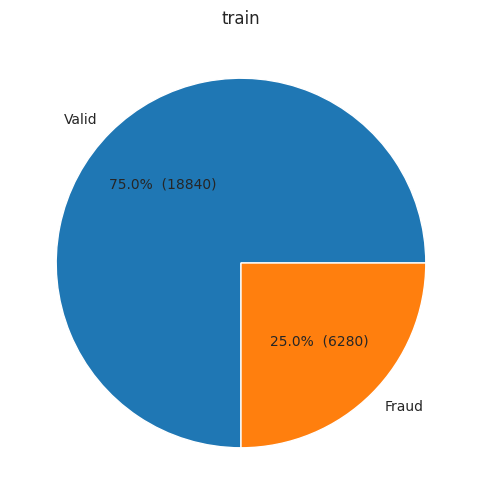

TX_FRAUD
0    2361
1     787
Name: count, dtype: int64


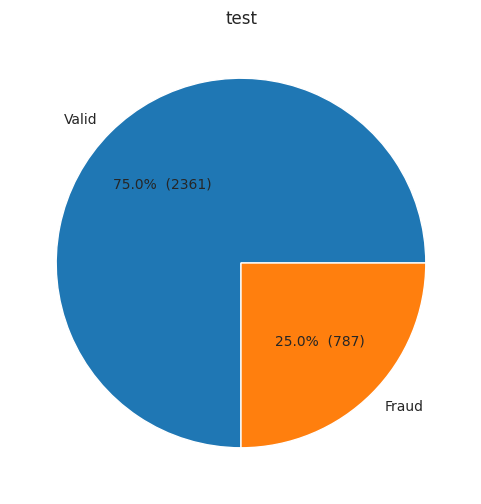

2024-05-01 10:08:43 [info     ] Downsample factor: 3
2024-05-01 10:08:43 [info     ] Train set size: 25120
2024-05-01 10:08:43 [info     ] Test set size: 3148
torch.Size([2, 8674])
torch.Size([28268, 4])
torch.Size([28268])
2024-05-01 10:10:01 [info     ] Model: GraphSAGE(
  (sage1): SAGEConv(4, 64, aggr=mean)
  (sage2): SAGEConv(64, 2, aggr=mean)
) dim_h=64 dim_in=4 dim_out=2
Epoch   0 | Train Loss: 0.801 | Train Acc:  37.62% | Val Loss: 0.82 | Val Acc: 34.56%
Epoch  10 | Train Loss: 0.436 | Train Acc:  83.13% | Val Loss: 0.56 | Val Acc: 77.83%
Epoch  20 | Train Loss: 0.409 | Train Acc:  84.87% | Val Loss: 0.58 | Val Acc: 78.94%
Epoch  30 | Train Loss: 0.392 | Train Acc:  85.33% | Val Loss: 0.58 | Val Acc: 79.54%
Epoch  40 | Train Loss: 0.380 | Train Acc:  85.78% | Val Loss: 0.56 | Val Acc: 78.81%
Epoch  50 | Train Loss: 0.376 | Train Acc:  86.15% | Val Loss: 0.56 | Val Acc: 79.26%
Epoch  60 | Train Loss: 0.370 | Train Acc:  86.11% | Val Loss: 0.55 | Val Acc: 79.54%
Epoch  70 | Train 

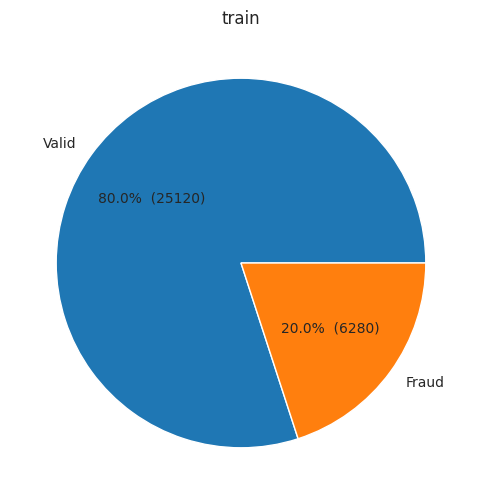

TX_FRAUD
0    3148
1     787
Name: count, dtype: int64


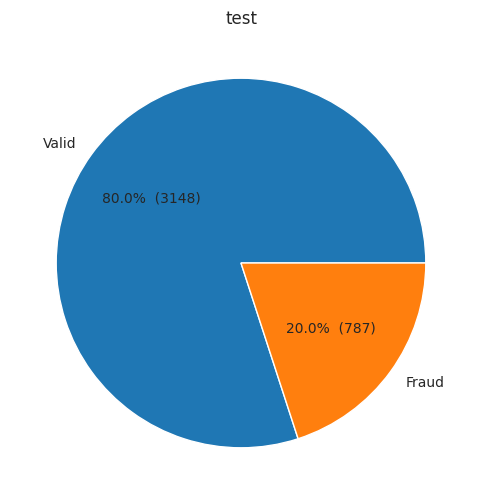

2024-05-01 10:10:15 [info     ] Downsample factor: 4
2024-05-01 10:10:15 [info     ] Train set size: 31400
2024-05-01 10:10:15 [info     ] Test set size: 3935
torch.Size([2, 10123])
torch.Size([35335, 4])
torch.Size([35335])
2024-05-01 10:11:36 [info     ] Model: GraphSAGE(
  (sage1): SAGEConv(4, 64, aggr=mean)
  (sage2): SAGEConv(64, 2, aggr=mean)
) dim_h=64 dim_in=4 dim_out=2
Epoch   0 | Train Loss: 0.725 | Train Acc:  53.84% | Val Loss: 0.58 | Val Acc: 75.32%
Epoch  10 | Train Loss: 0.404 | Train Acc:  84.69% | Val Loss: 0.54 | Val Acc: 81.55%
Epoch  20 | Train Loss: 0.383 | Train Acc:  85.86% | Val Loss: 0.54 | Val Acc: 81.96%
Epoch  30 | Train Loss: 0.363 | Train Acc:  86.38% | Val Loss: 0.52 | Val Acc: 82.29%
Epoch  40 | Train Loss: 0.351 | Train Acc:  86.86% | Val Loss: 0.49 | Val Acc: 82.69%
Epoch  50 | Train Loss: 0.345 | Train Acc:  87.07% | Val Loss: 0.50 | Val Acc: 82.36%
Epoch  60 | Train Loss: 0.340 | Train Acc:  87.18% | Val Loss: 0.49 | Val Acc: 82.47%
Epoch  70 | Train

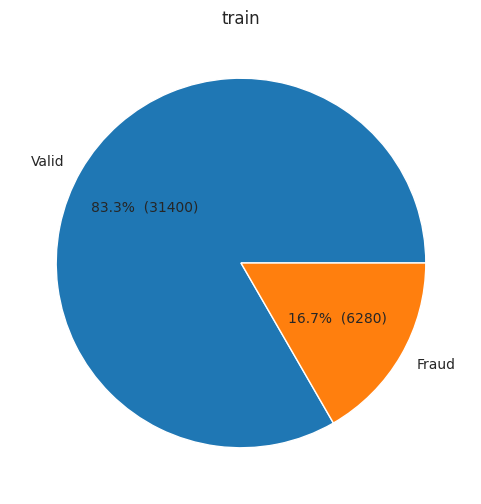

TX_FRAUD
0    3935
1     787
Name: count, dtype: int64


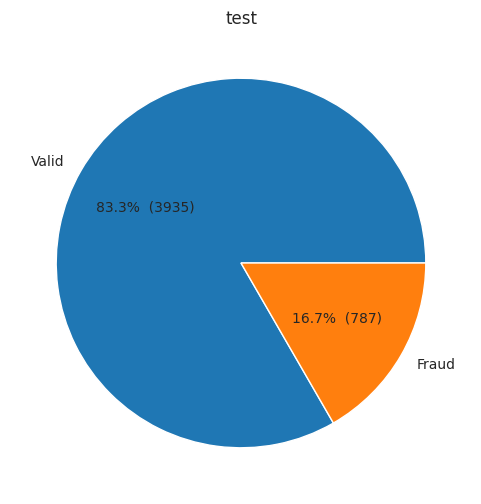

2024-05-01 10:11:54 [info     ] Downsample factor: 5
2024-05-01 10:11:54 [info     ] Train set size: 37680
2024-05-01 10:11:54 [info     ] Test set size: 4722
torch.Size([2, 11846])
torch.Size([42402, 4])
torch.Size([42402])
2024-05-01 10:13:32 [info     ] Model: GraphSAGE(
  (sage1): SAGEConv(4, 64, aggr=mean)
  (sage2): SAGEConv(64, 2, aggr=mean)
) dim_h=64 dim_in=4 dim_out=2
Epoch   0 | Train Loss: 0.668 | Train Acc:  70.54% | Val Loss: 0.63 | Val Acc: 69.31%
Epoch  10 | Train Loss: 0.361 | Train Acc:  85.61% | Val Loss: 0.46 | Val Acc: 83.16%
Epoch  20 | Train Loss: 0.342 | Train Acc:  87.05% | Val Loss: 0.46 | Val Acc: 84.14%
Epoch  30 | Train Loss: 0.325 | Train Acc:  87.83% | Val Loss: 0.45 | Val Acc: 84.24%
Epoch  40 | Train Loss: 0.317 | Train Acc:  88.43% | Val Loss: 0.44 | Val Acc: 84.63%
Epoch  50 | Train Loss: 0.313 | Train Acc:  88.68% | Val Loss: 0.44 | Val Acc: 84.43%
Epoch  60 | Train Loss: 0.310 | Train Acc:  88.64% | Val Loss: 0.43 | Val Acc: 84.84%
Epoch  70 | Train

In [13]:
RESULTS_GRAPH_SAGE = {}
for downsample_factor in [3, 4, 5]:
    downsample_train_df = downsample_majority_class(train_df, downsample_factor)
    plot_fraud_proportion(downsample_train_df, label="train")

    downsample_test_df = downsample_majority_class(test_df, downsample_factor)
    plot_fraud_proportion(downsample_test_df, label="test")

    downsample_test_df.reset_index(drop=True, inplace=True)
    downsample_test_df["TRANSACTION_ID"] = max(downsample_train_df["TRANSACTION_ID"]) + 1 + downsample_test_df.index
    downsample_test_df.index = range(min(downsample_test_df["TRANSACTION_ID"]), max(downsample_test_df["TRANSACTION_ID"]) + 1)

    logger.info(f"Downsample factor: {downsample_factor}")
    logger.info(f"Train set size: {len(downsample_train_df)}")
    logger.info(f"Test set size: {len(downsample_test_df)}")

    # Create synthetic graph data
    graph_data = create_synthetic_data(downsample_train_df, downsample_test_df)

    # Create a GraphSAGE model
    dim_in = graph_data.num_features
    dim_h = 64  # Hidden layer dimension
    dim_out = 2  # Output layer (2 classes for binary classification)
    sage_model = GraphSAGE(dim_in, dim_h, dim_out)
    logger.info(f"Model: {sage_model}", dim_in=dim_in, dim_h=dim_h, dim_out=dim_out)

    # Create a DataLoader for training and validation
    train_loader = DataLoader([graph_data], batch_size=1, shuffle=False)

    # Train the model for 20 epochs
    sage_model.fit(train_loader, epochs=250)

    sage_model.eval()
    _, log_probs =  sage_model.forward(graph_data.x, graph_data.edge_index)

    predicted_classes = log_probs.argmax(dim=1)

    df = pd.concat([downsample_train_df, downsample_test_df])
    df["predicted_class"] = log_probs.argmax(dim=1).tolist()

    metrics = get_metrics(df.iloc[downsample_test_df["TRANSACTION_ID"]]["TX_FRAUD"],  df.iloc[downsample_test_df["TRANSACTION_ID"]]["predicted_class"])
    RESULTS_GRAPH_SAGE.update({downsample_factor: metrics})
    logger.info(f"Metrics: {metrics}")



# XGBoost Model

TX_FRAUD
0    18840
1     6280
Name: count, dtype: int64


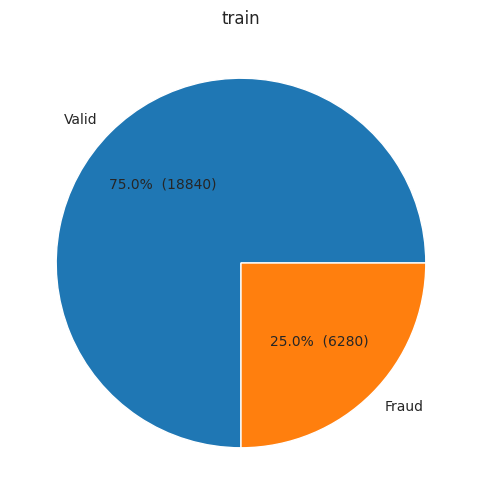

TX_FRAUD
0    2361
1     787
Name: count, dtype: int64


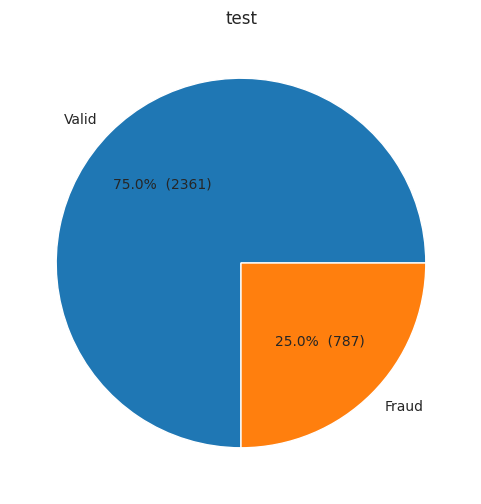

2024-05-01 10:13:52 [info     ] Metrics: {'f1': 0.22507403751233956, 'precision': 0.504424778761062, 'recall': 0.144853875476493, 'accuracy': 0.7506353240152478, 'auc': 0.5487081745023294}
TX_FRAUD
0    25120
1     6280
Name: count, dtype: int64


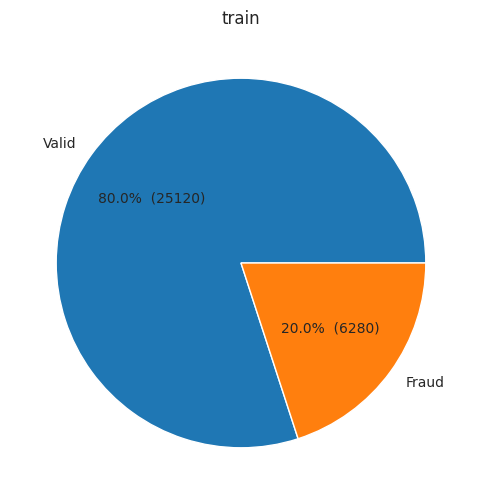

TX_FRAUD
0    3148
1     787
Name: count, dtype: int64


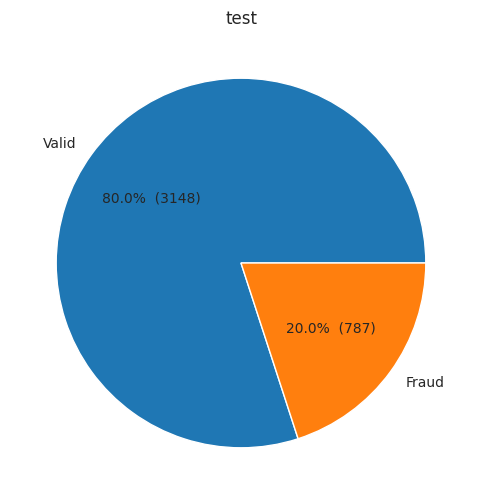

2024-05-01 10:13:53 [info     ] Metrics: {'f1': 0.22135161606268366, 'precision': 0.4829059829059829, 'recall': 0.14358322744599747, 'accuracy': 0.7979669631512071, 'auc': 0.5525730622617534}
TX_FRAUD
0    31400
1     6280
Name: count, dtype: int64


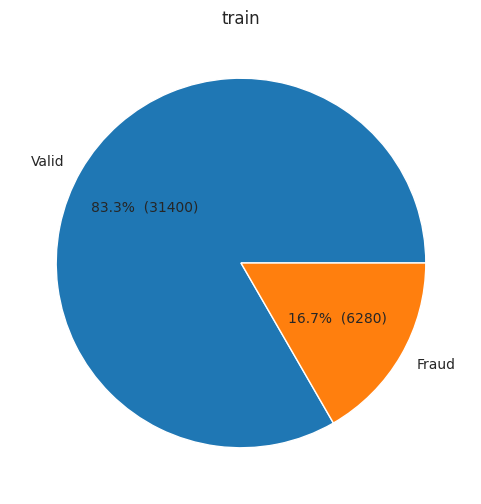

TX_FRAUD
0    3935
1     787
Name: count, dtype: int64


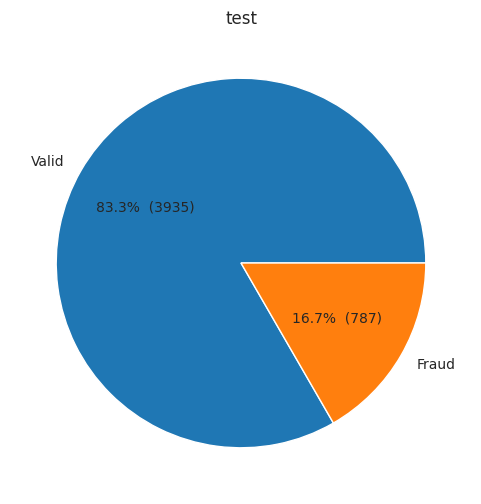

2024-05-01 10:13:55 [info     ] Metrics: {'f1': 0.18219461697722567, 'precision': 0.49162011173184356, 'recall': 0.11181702668360864, 'accuracy': 0.8326980093180856, 'auc': 0.5443456162642948}


In [14]:
# train a XGBoost model
import xgboost as xgb
from sklearn.metrics import accuracy_score

RESULTS_XGBOOST = {}
for downsample_factor in [3, 4, 5]:
  downsample_train_df = downsample_majority_class(train_df, downsample_factor)
  plot_fraud_proportion(downsample_train_df, label="train")

  downsample_test_df = downsample_majority_class(test_df, downsample_factor)
  plot_fraud_proportion(downsample_test_df, label="test")

  XGB_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=50, random_state=42)

  x_downsample_train_df, y_downsample_train_df = downsample_train_df[FEATURES_TO_TRAIN_GNN], downsample_train_df['TX_FRAUD']
  x_downsample_test_df, y_downsample_test_df = downsample_test_df[FEATURES_TO_TRAIN_GNN], downsample_test_df['TX_FRAUD']

  # Create a StandardScaler object
  scaler = StandardScaler()
  # Fit the scaler to the features and transform
  x_downsample_train_df = scaler.fit_transform(x_downsample_train_df)

  # Create a StandardScaler object
  scaler = StandardScaler()
  # Fit the scaler to the features and transform
  x_downsample_test_df = scaler.fit_transform(x_downsample_test_df)

  XGB_model.fit(x_downsample_train_df, y_downsample_train_df)

  y_pred_train = XGB_model.predict(x_downsample_train_df)
  y_pred_test = XGB_model.predict(x_downsample_test_df)

  metrics = get_metrics(y_downsample_test_df, y_pred_test)
  RESULTS_XGBOOST.update({downsample_factor: metrics})
  logger.info(f"Metrics: {metrics}")




# GNNCFD
Extention of Graph-SAGE proposed in "[Graph Neural Network for Credit Card Fraud
Detection"](https://ieeexplore.ieee.org/document/9736204)

In [15]:
import networkx as nx
from torch_geometric.data import Data
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import torch
from torch_geometric.nn import SAGEConv, BatchNorm
import torch.nn.functional as F
from torch_geometric.data import Data

class GNNCFD(torch.nn.Module):
    def __init__(self, n_inputs, n_hidden, n_out, edge_time_intervals, num_of_samples=20, edge_weights=None):
        super(GNNCFD, self).__init__()
        # Initialize layers
        self.conv1 = SAGEConv(n_inputs, n_hidden)
        #self.norm1 = torch.nn.BatchNorm1d(n_hidden)
        self.conv2 = SAGEConv(n_hidden, n_out)
        #self.norm2 = torch.nn.BatchNorm1d(n_out)
        self.att_weight_vector = torch.nn.Parameter(torch.Tensor(n_inputs * 2, 1))
        self.att_weight_matrix = torch.nn.Parameter(torch.Tensor(n_inputs, n_inputs))
        torch.nn.init.xavier_uniform_(self.att_weight_vector.data)
        torch.nn.init.xavier_uniform_(self.att_weight_matrix.data)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
        self.num_of_samples = num_of_samples
        if edge_weights is None:
          self.edge_weights = torch.nn.Parameter(torch.Tensor(1))
        else:
          self.edge_weights = edge_weights
        self.edge_time_intervals = edge_time_intervals

    def forward(self, x, edge_index):
      sampling_probs = self.calculate_sampling_probs(x, edge_index, self.edge_weights)
      sampled_edge_index, sampled_time_intervals = self.weighted_sample(
          edge_index, sampling_probs, num_samples=self.num_of_samples
      )

      src, tgt = sampled_edge_index[0], sampled_edge_index[1]
      att_scores = self.calculate_attention_scores(x[src], x[tgt], sampled_time_intervals)

      # We are not using attention scores at this time
      #x[src] *= att_scores.unsqueeze(-1)  # Apply attention to node features
      #x_updated = x.clone()  # Clone x to avoid in-place operations
      #x_updated[src] = x[src] * att_scores.unsqueeze(1)
      #x = x_updated

      x = self.conv1(x, edge_index)
      x = F.normalize(x, p=2, dim=-1)
      x = F.relu(x)
      x = F.dropout(x, training=self.training)
      x = self.conv2(x, edge_index)
      #x = torch.sigmoid(x)
      return x


    def calculate_attention_scores(self, src_features, tgt_features, time_intervals):
      transformed_src = torch.matmul(src_features, self.att_weight_matrix)
      transformed_tgt = torch.matmul(tgt_features, self.att_weight_matrix)

      concatenated_features = torch.cat((transformed_src, transformed_tgt), dim=1)
      attention_logits = (concatenated_features * self.att_weight_vector.T).sum(dim=1)

      attention_logits = F.leaky_relu(attention_logits)

      attention_logits = attention_logits - attention_logits.max()
      att_scores = torch.exp(attention_logits * self.edge_time_intervals)
      return att_scores


    def calculate_sampling_probs(self, x, edge_index, edge_weight):
        src_features = x[edge_index[0]]
        tgt_features = x[edge_index[1]]
        cosine_sim = F.cosine_similarity(src_features, tgt_features)

        scaled_similarities = torch.exp(cosine_sim) * edge_weight

        sampling_probs = scaled_similarities / torch.sum(scaled_similarities, dim=0, keepdim=True)
        return sampling_probs

    def weighted_sample(self, edge_index, sampling_probs, num_samples=20):
      sampled_edges = []
      sampled_intervals = []
      for node in torch.unique(edge_index[0]):
          mask = edge_index[0] == node
          node_probs = sampling_probs[mask]
          node_edges = edge_index[:, mask]
          edge_time_intervals = self.edge_time_intervals[mask]

          if node_probs.size(0) > num_samples:
              chosen_idx = torch.multinomial(node_probs, num_samples, replacement=False)
              sampled_edges.append(node_edges[:, chosen_idx])
              sampled_intervals.append(edge_time_intervals[chosen_idx])
          else:
              sampled_edges.append(node_edges)
              sampled_intervals.append(edge_time_intervals)

      sampled_edges = torch.cat(sampled_edges, dim=1)

      return sampled_edges, sampled_intervals


    def fit(self, data, epochs):
      criterion = torch.nn.CrossEntropyLoss()
      optimizer = self.optimizer

      self.train()
      for epoch in range(epochs + 1):
          acc = 0
          val_loss = 0
          val_acc = 0

          # Train on batches
          for batch in data:
              optimizer.zero_grad()
              out = self(batch.x, batch.edge_index)
              loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
              acc += accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
              loss.backward()
              optimizer.step()

              # Validation
              val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
              val_acc += accuracy(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])

          # Print metrics every 10 epochs
          if epoch % 10 == 0:
              print(f'Epoch {epoch:>3} | Train Loss: {loss/len(data):.3f} '
                    f'| Train Acc: {acc/len(data)*100:>6.2f}% | Val Loss: '
                    f'{val_loss/len(data):.2f} | Val Acc: '
                    f'{val_acc/len(data)*100:.2f}%')

## Experimentation Data Downsampling

TX_FRAUD
0    18840
1     6280
Name: count, dtype: int64


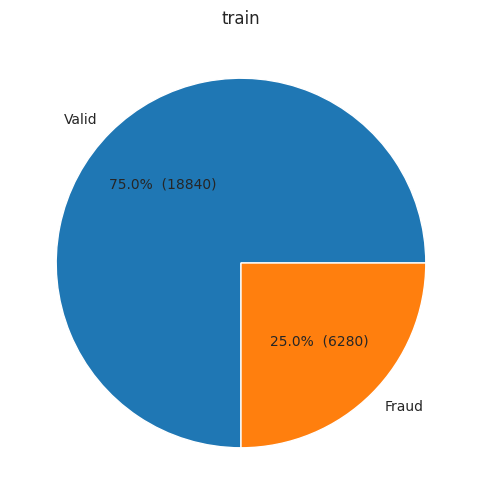

TX_FRAUD
0    2361
1     787
Name: count, dtype: int64


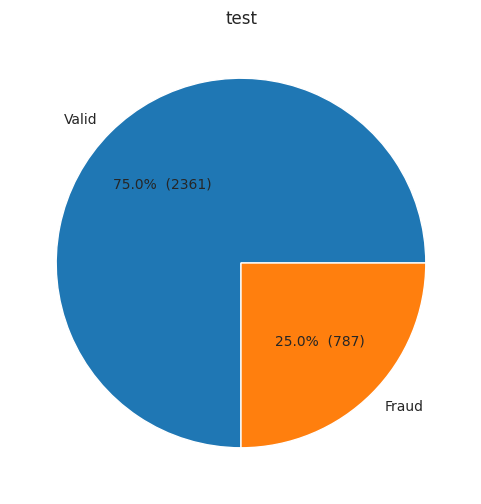

2024-05-01 10:17:22 [info     ] Downsample factor: 3
2024-05-01 10:17:22 [info     ] Train set size: 25120
2024-05-01 10:17:22 [info     ] Test set size: 3148
torch.Size([2, 8674])
torch.Size([28268, 4])
torch.Size([28268])
2024-05-01 10:18:29 [info     ] Model Summary:                 dim_h=64 dim_in=4 dim_out=2 num_of_samples=20
Epoch   0 | Train Loss: 0.685 | Train Acc:  59.90% | Val Loss: 0.70 | Val Acc: 50.03%
Epoch  10 | Train Loss: 0.493 | Train Acc:  78.73% | Val Loss: 0.54 | Val Acc: 76.62%
Epoch  20 | Train Loss: 0.421 | Train Acc:  82.03% | Val Loss: 0.52 | Val Acc: 78.24%
Epoch  30 | Train Loss: 0.404 | Train Acc:  83.59% | Val Loss: 0.51 | Val Acc: 78.65%
Epoch  40 | Train Loss: 0.392 | Train Acc:  84.75% | Val Loss: 0.51 | Val Acc: 79.45%
Epoch  50 | Train Loss: 0.386 | Train Acc:  84.93% | Val Loss: 0.51 | Val Acc: 79.45%
Epoch  60 | Train Loss: 0.382 | Train Acc:  85.44% | Val Loss: 0.51 | Val Acc: 79.45%
Epoch  70 | Train Loss: 0.377 | Train Acc:  85.49% | Val Loss: 0.

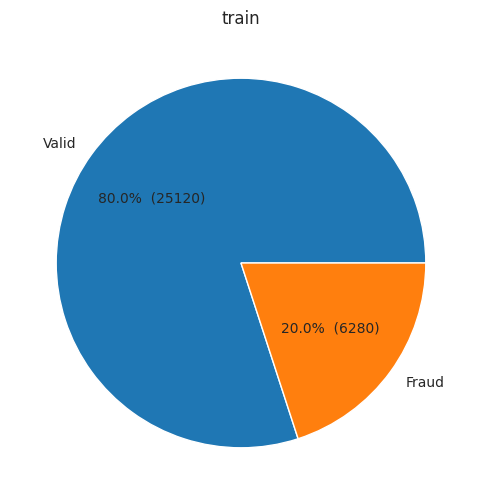

TX_FRAUD
0    3148
1     787
Name: count, dtype: int64


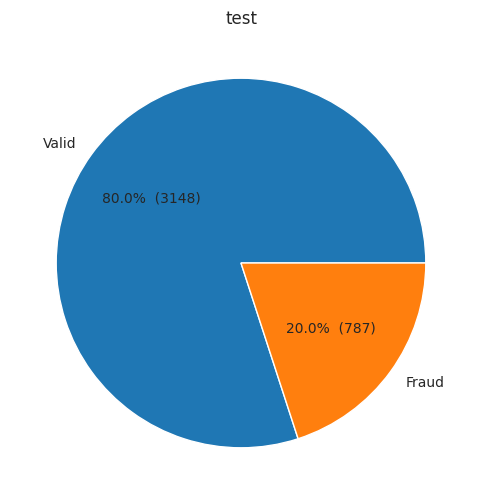

2024-05-01 10:22:23 [info     ] Downsample factor: 4
2024-05-01 10:22:23 [info     ] Train set size: 31400
2024-05-01 10:22:23 [info     ] Test set size: 3935
torch.Size([2, 10123])
torch.Size([35335, 4])
torch.Size([35335])
2024-05-01 10:23:45 [info     ] Model Summary:                 dim_h=64 dim_in=4 dim_out=2 num_of_samples=20
Epoch   0 | Train Loss: 0.646 | Train Acc:  80.58% | Val Loss: 0.65 | Val Acc: 79.95%
Epoch  10 | Train Loss: 0.457 | Train Acc:  81.84% | Val Loss: 0.51 | Val Acc: 80.28%
Epoch  20 | Train Loss: 0.388 | Train Acc:  82.67% | Val Loss: 0.47 | Val Acc: 81.22%
Epoch  30 | Train Loss: 0.374 | Train Acc:  83.57% | Val Loss: 0.46 | Val Acc: 81.30%
Epoch  40 | Train Loss: 0.365 | Train Acc:  84.63% | Val Loss: 0.47 | Val Acc: 81.19%
Epoch  50 | Train Loss: 0.357 | Train Acc:  85.49% | Val Loss: 0.45 | Val Acc: 81.93%
Epoch  60 | Train Loss: 0.350 | Train Acc:  86.19% | Val Loss: 0.45 | Val Acc: 82.06%
Epoch  70 | Train Loss: 0.347 | Train Acc:  86.25% | Val Loss: 0

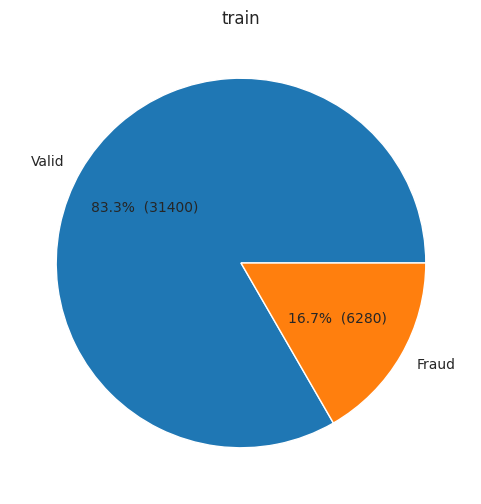

TX_FRAUD
0    3935
1     787
Name: count, dtype: int64


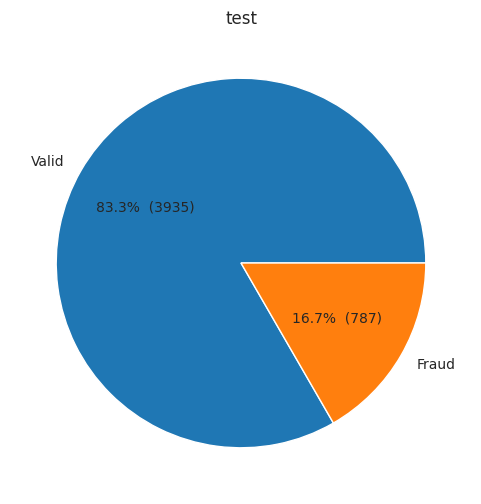

2024-05-01 10:28:54 [info     ] Downsample factor: 5
2024-05-01 10:28:54 [info     ] Train set size: 37680
2024-05-01 10:28:54 [info     ] Test set size: 4722
torch.Size([2, 11846])
torch.Size([42402, 4])
torch.Size([42402])
2024-05-01 10:30:37 [info     ] Model Summary:                 dim_h=64 dim_in=4 dim_out=2 num_of_samples=20
Epoch   0 | Train Loss: 0.687 | Train Acc:  56.47% | Val Loss: 0.70 | Val Acc: 41.51%
Epoch  10 | Train Loss: 0.461 | Train Acc:  84.04% | Val Loss: 0.49 | Val Acc: 83.52%
Epoch  20 | Train Loss: 0.366 | Train Acc:  85.11% | Val Loss: 0.44 | Val Acc: 83.80%
Epoch  30 | Train Loss: 0.343 | Train Acc:  85.20% | Val Loss: 0.42 | Val Acc: 83.95%
Epoch  40 | Train Loss: 0.337 | Train Acc:  86.25% | Val Loss: 0.42 | Val Acc: 83.99%
Epoch  50 | Train Loss: 0.329 | Train Acc:  86.84% | Val Loss: 0.42 | Val Acc: 84.03%
Epoch  60 | Train Loss: 0.322 | Train Acc:  87.32% | Val Loss: 0.42 | Val Acc: 84.60%
Epoch  70 | Train Loss: 0.320 | Train Acc:  87.55% | Val Loss: 0

In [17]:
RESULTS_GNNCFD = {}

for downsample_factor in [3, 4, 5]:

  downsample_train_df = downsample_majority_class(train_df, downsample_factor)
  plot_fraud_proportion(downsample_train_df, label="train")

  downsample_test_df = downsample_majority_class(test_df, downsample_factor)
  plot_fraud_proportion(downsample_test_df, label="test")

  downsample_test_df.reset_index(drop=True, inplace=True)
  downsample_test_df["TRANSACTION_ID"] = max(downsample_train_df["TRANSACTION_ID"]) + 1 + downsample_test_df.index
  downsample_test_df.index = range(min(downsample_test_df["TRANSACTION_ID"]), max(downsample_test_df["TRANSACTION_ID"]) + 1)

  logger.info(f"Downsample factor: {downsample_factor}")
  logger.info(f"Train set size: {len(downsample_train_df)}")
  logger.info(f"Test set size: {len(downsample_test_df)}")


  # Create synthetic graph data
  graph_data = create_synthetic_data(downsample_train_df, downsample_test_df)

  # Create a GNNCFD model
  dim_in = graph_data.num_features
  dim_h = 64  # Hidden layer dimension
  dim_out = 2  # Output layer (2 classes for binary classification)
  num_of_samples = 20  # Number of samples for each node
  edge_time_intervals = graph_data.edge_time_intervals
  sage_model = GNNCFD(dim_in, dim_h, dim_out, edge_time_intervals, num_of_samples)

  logger.info("Model Summary:", dim_in=dim_in, dim_h=dim_h, dim_out=dim_out, num_of_samples=num_of_samples)

  # Create a DataLoader for training and validation
  train_loader = DataLoader([graph_data], batch_size=1, shuffle=False)

  # Train the model for 20 epochs
  sage_model.fit(train_loader, epochs=250)

  sage_model.eval()
  log_probs =  sage_model.forward(graph_data.x, graph_data.edge_index)

  predicted_classes = log_probs.argmax(dim=1)

  metrics = get_metrics(df.iloc[downsample_test_df["TRANSACTION_ID"]]["TX_FRAUD"],  df.iloc[downsample_test_df["TRANSACTION_ID"]]["predicted_class"])
  RESULTS_GNNCFD.update({downsample_factor: metrics})
  logger.info(f"Metrics: {metrics}")



In [18]:
'''
auc = roc_auc_score(df.iloc[downsample_test_df["TRANSACTION_ID"]]["TX_FRAUD"],  df.iloc[downsample_test_df["TRANSACTION_ID"]]["predicted_class"])
auc_s2 = roc_auc_score(df.iloc[downsample_test_df[downsample_test_df["TX_FRAUD_SCENARIO"].isin([0,2])]["TRANSACTION_ID"]]["TX_FRAUD"], df.iloc[downsample_test_df[downsample_test_df["TX_FRAUD_SCENARIO"].isin([0,2])]["TRANSACTION_ID"]]["predicted_class"])
auc_s3 = roc_auc_score(df.iloc[downsample_test_df[downsample_test_df["TX_FRAUD_SCENARIO"].isin([0,3])]["TRANSACTION_ID"]]["TX_FRAUD"], df.iloc[downsample_test_df[downsample_test_df["TX_FRAUD_SCENARIO"].isin([0,3])]["TRANSACTION_ID"]]["predicted_class"])

print(f"AUC: {auc:.4f}")
print(f"AUC SCENARIO 2: {auc_s2:.4f}")
print(f"AUC SCENARIO 3: {auc_s3:.4f}")

confusion_matrix = pd.crosstab(df["TX_FRAUD"], df["predicted_class"])
print(confusion_matrix)

confusion_matrix = pd.crosstab(df.iloc[downsample_test_df[downsample_test_df["TX_FRAUD_SCENARIO"].isin([0,2])]["TRANSACTION_ID"]]["TX_FRAUD"], df.iloc[downsample_test_df[downsample_test_df["TX_FRAUD_SCENARIO"].isin([0,2])]["TRANSACTION_ID"]]["predicted_class"])
print(confusion_matrix)

confusion_matrix = pd.crosstab(df.iloc[downsample_test_df[downsample_test_df["TX_FRAUD_SCENARIO"].isin([0,3])]["TRANSACTION_ID"]]["TX_FRAUD"], df.iloc[downsample_test_df[downsample_test_df["TX_FRAUD_SCENARIO"].isin([0,3])]["TRANSACTION_ID"]]["predicted_class"])
print(confusion_matrix)
'''



'\nauc = roc_auc_score(df.iloc[downsample_test_df["TRANSACTION_ID"]]["TX_FRAUD"],  df.iloc[downsample_test_df["TRANSACTION_ID"]]["predicted_class"])\nauc_s2 = roc_auc_score(df.iloc[downsample_test_df[downsample_test_df["TX_FRAUD_SCENARIO"].isin([0,2])]["TRANSACTION_ID"]]["TX_FRAUD"], df.iloc[downsample_test_df[downsample_test_df["TX_FRAUD_SCENARIO"].isin([0,2])]["TRANSACTION_ID"]]["predicted_class"])\nauc_s3 = roc_auc_score(df.iloc[downsample_test_df[downsample_test_df["TX_FRAUD_SCENARIO"].isin([0,3])]["TRANSACTION_ID"]]["TX_FRAUD"], df.iloc[downsample_test_df[downsample_test_df["TX_FRAUD_SCENARIO"].isin([0,3])]["TRANSACTION_ID"]]["predicted_class"])\n\nprint(f"AUC: {auc:.4f}")\nprint(f"AUC SCENARIO 2: {auc_s2:.4f}")\nprint(f"AUC SCENARIO 3: {auc_s3:.4f}")\n\nconfusion_matrix = pd.crosstab(df["TX_FRAUD"], df["predicted_class"])\nprint(confusion_matrix)\n\nconfusion_matrix = pd.crosstab(df.iloc[downsample_test_df[downsample_test_df["TX_FRAUD_SCENARIO"].isin([0,2])]["TRANSACTION_ID"]]["T

# Plots

In [22]:
RESULTS_XGBOOST
RESULTS_GRAPH_SAGE
RESULTS_GNNCFD

#Make a json with the 3 results
results = {
    "XGBOOST": RESULTS_XGBOOST,
    "GRAPH_SAGE": RESULTS_GRAPH_SAGE,
    "GNNCFD": RESULTS_GNNCFD
}
json.dumps(results)

'{"XGBOOST": {"3": {"f1": 0.22507403751233956, "precision": 0.504424778761062, "recall": 0.144853875476493, "accuracy": 0.7506353240152478, "auc": 0.5487081745023294}, "4": {"f1": 0.22135161606268366, "precision": 0.4829059829059829, "recall": 0.14358322744599747, "accuracy": 0.7979669631512071, "auc": 0.5525730622617534}, "5": {"f1": 0.18219461697722567, "precision": 0.49162011173184356, "recall": 0.11181702668360864, "accuracy": 0.8326980093180856, "auc": 0.5443456162642948}}, "GRAPH_SAGE": {"3": {"f1": 0.44382544103992566, "precision": 0.8241379310344827, "recall": 0.3036848792884371, "accuracy": 0.809720457433291, "auc": 0.6410419313850064}, "4": {"f1": 0.2902208201892745, "precision": 0.8414634146341463, "recall": 0.17534942820838628, "accuracy": 0.8284625158831004, "auc": 0.5835451080050825}, "5": {"f1": 0.23220153340635266, "precision": 0.8412698412698413, "recall": 0.13468869123252858, "accuracy": 0.8515459551037696, "auc": 0.5648030495552733}}, "GNNCFD": {"3": {"f1": 0.5932584

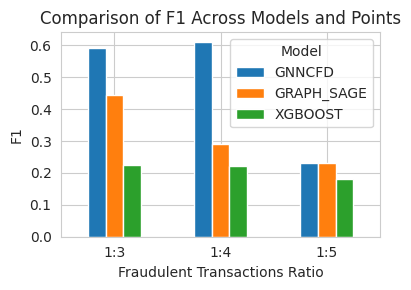

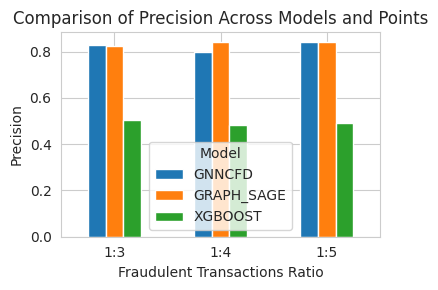

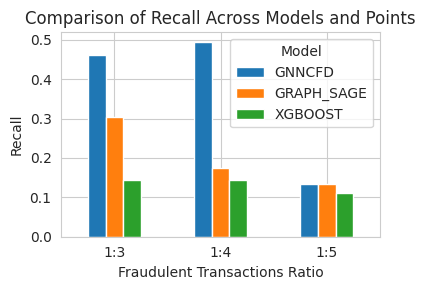

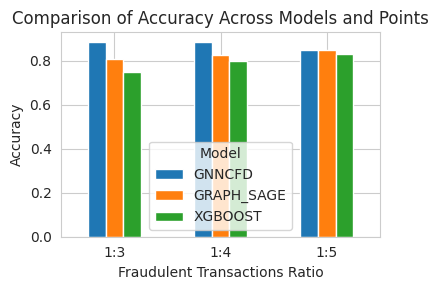

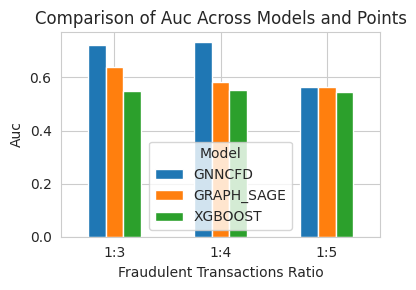

In [34]:
# Extracting and structuring data for plotting
metrics = ['f1', 'precision', 'recall', 'accuracy', 'auc']
data = {metric: [] for metric in metrics}

for model in results:
    for point in results[model]:
        for metric in metrics:
            if metric in results[model][point]:
                data[metric].append((model, f"1:{point}", results[model][point][metric]))

# Creating a DataFrame for each metric and plotting
for metric in metrics:
    df = pd.DataFrame(data[metric], columns=['Model', 'Point', metric])
    df_pivot = df.pivot(index="Point", columns="Model", values=metric)

    # Plotting
    ax = df_pivot.plot(kind='bar', figsize=(10*.4, 5*.6))
    ax.set_title(f'Comparison of {metric.capitalize()} Across Models and Points')
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Fraudulent Transactions Ratio")
    plt.xticks(rotation=0)  # Rotates X-axis labels to horizontal
    plt.legend(title="Model")
    plt.tight_layout()
    # do not print the legend
    #plt.legend(frameon=False, labels=[])

    plt.show()